In [1]:
import os
import sys
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import math

import import_ipynb
from CustomDataset import ControlsDataset
from Model import ConvNet
from Trainer import Trainer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device', device)
torch.cuda.empty_cache()

importing Jupyter notebook from CustomDataset.ipynb
importing Jupyter notebook from Model.ipynb
importing Jupyter notebook from Trainer.ipynb
using device cuda


In [2]:
torch.cuda.empty_cache()

In [3]:
dataset = ControlsDataset(stack_size = 3,       #each stack contains this many images
                          stride = 30,          #each image in the stack is seperated by this many frames
                          batch_size = 15,      #15 random stacks
                          size = 0,             #0 is entire dataset, anything else is a cutoff
                          img_folder = '../data/cropped_vflip/', 
                          csv_path = '../data/cropped_vflip/data.csv')
print("Data size", len(dataset.labels))

Total training stacks 733
Total validation stacks 733
Data size 22038


In [4]:
outputs = 1
image_shape = dataset[0]['image'].shape

net = ConvNet(outputs, image_shape).to(device)
print("number of parameters: ", sum(p.numel() for p in net.parameters()))

units after conv 22400
conv parameters:  48992
fc parameters:  12546241
number of parameters:  12595233


In [5]:
optimizer = optim.Adam(net.parameters())
criterion = nn.MSELoss()
trainer = Trainer(device, net, dataset, optimizer, criterion)


Training Loss: 0.10219
Validation Loss: 0.10196


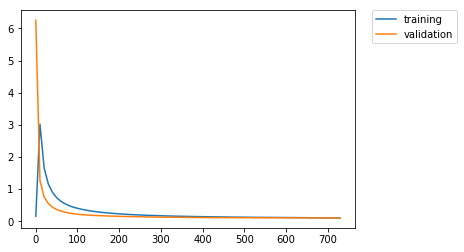


Training Loss: 0.04675
Validation Loss: 0.08846


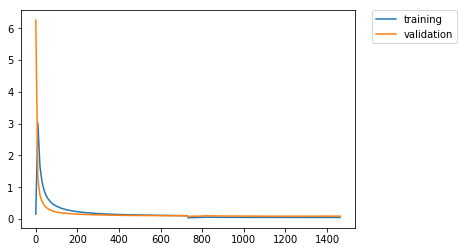


Training Loss: 0.04127
Validation Loss: 0.09084


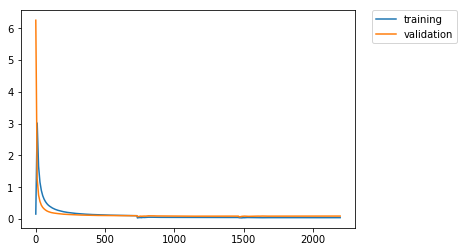


Training Loss: 0.03571
Validation Loss: 0.09686


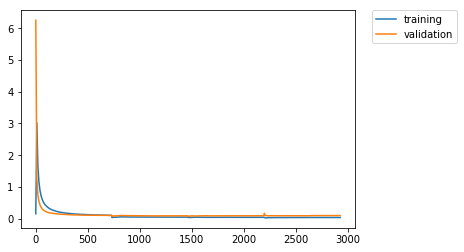


Training Loss: 0.03289
Validation Loss: 0.09854


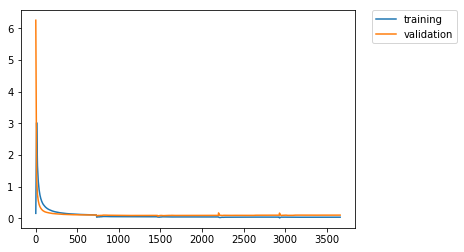


Training Loss: 0.02939
Validation Loss: 0.09778


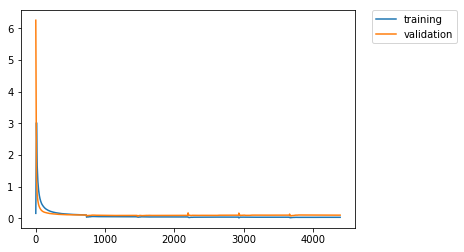


Training Loss: 0.02623
Validation Loss: 0.09984


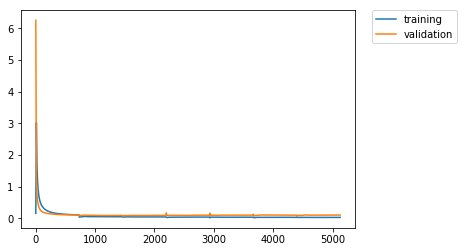


Training Loss: 0.0249
Validation Loss: 0.09861


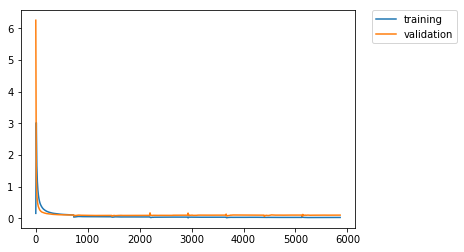


Training Loss: 0.02154
Validation Loss: 0.10085


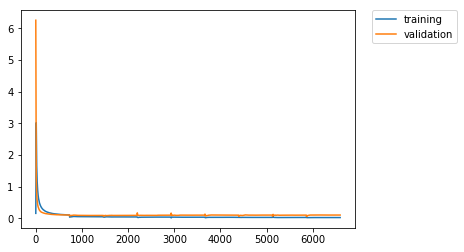


Training Loss: 0.01993
Validation Loss: 0.10147


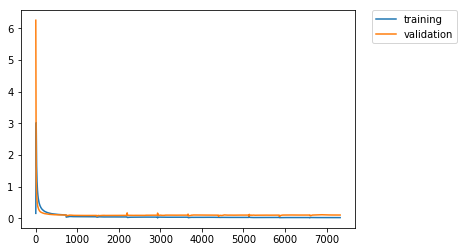

In [6]:
epochs = 10
report_period = 10
trainer.fit(epochs, report_period)

In [7]:
print(torch.cuda.max_memory_cached(device))
torch.cuda.empty_cache()
print(torch.cuda.memory_cached(device))

438304768
203423744



Went through 732 batches
Predicted


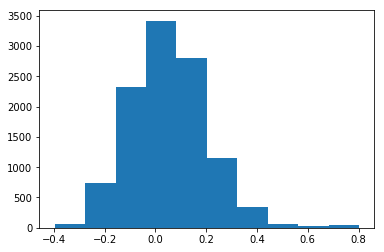

Correct


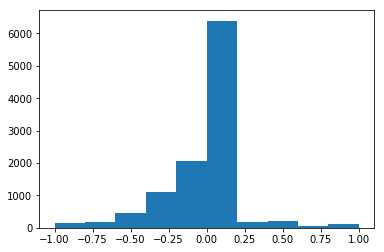

Validation Loss: 0.09939004579823607


In [9]:
from tqdm.notebook import tqdm_notebook
def validation_accuracy(trainer):
    loss = 0
    predictions = []
    answers = []
    trainer.model.eval()
    for i_batch, sampled_batch in tqdm_notebook(enumerate(trainer.dataset.validloader),
                                                       total=len(trainer.dataset.validloader)):
        torch.cuda.empty_cache()
        images = sampled_batch['image'].to(trainer.device).float()
        controls = sampled_batch['control'].to(trainer.device).float()
        controls = torch.flatten(controls)
        #forward pass
        prediction = trainer.model(images)
        prediction = torch.flatten(prediction)
        loss += trainer.criterion(prediction,controls).detach().cpu().numpy()
        predictions += list(prediction.detach().cpu().numpy())
        answers+= list(controls.detach().cpu().numpy())
        
    print("Went through "+str(i_batch)+" batches")
    print("Predicted")
    plt.hist(predictions)
    plt.show()
    print("Correct")
    plt.hist(answers)
    plt.show()
    return loss/i_batch

loss = validation_accuracy(trainer)
print("Validation Loss: {}".format(loss))

In [10]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

net.conv1.register_forward_hook(get_activation('conv1'))
net.conv2.register_forward_hook(get_activation('conv2'))
net.conv3.register_forward_hook(get_activation('conv3'))

def getActivations(name):
    act = activation[name].squeeze()
    act = act.cpu()
    act = act.detach().numpy()
    print("Convolution: "+name)
    print("Activation size: "+str(act.shape[1:]))

    nrows = 2
    ncols = 4
    
    fig, axarr = plt.subplots(nrows,ncols, figsize=(12, 4))
    for x in range(nrows):
        for y in range(ncols):
            axarr[x][y].imshow(act[ncols*x + y], cmap='gray')
    plt.show()

Convolution: conv1
Activation size: (55, 100)


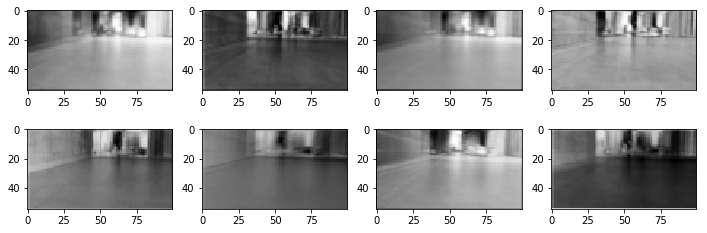

Convolution: conv2
Activation size: (14, 25)


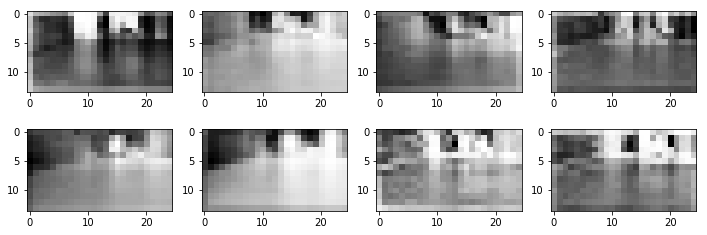

Convolution: conv3
Activation size: (14, 25)


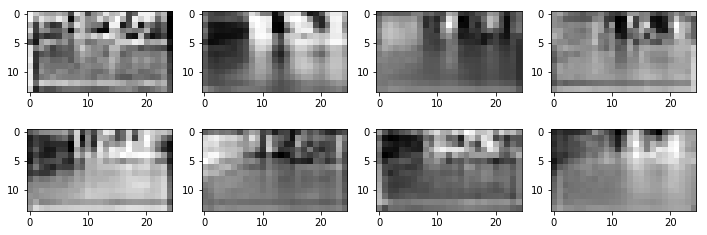

Output: tensor([[0.0294]], device='cuda:0', grad_fn=<AddmmBackward>)
Control: tensor([-0.])


In [11]:
net.eval()
for i, batch in enumerate(dataset.validloader):
    if i > 0:
        break
    image = batch['image'][0].float()
    control = batch['control'][0].float()
    image = image.reshape(1,9,220,400).to(device)
    output = net(image)
    
getActivations("conv1")
getActivations("conv2")
getActivations("conv3")
print("Output: "+str(output))
print("Control: "+str(control))